In [1]:
import numpy as np
from coupled_LDS import *
import scipy.stats as stats
import scipy.linalg
from utils import *
import matplotlib.pyplot as plt
from plotting_utils import *
import pymanopt 
import autograd.numpy as anp 
from sippy_unipi import *
from sklearn.linear_model import LinearRegression
import scipy.linalg as sl
import seaborn
seaborn.set_context("talk")
import os

# Standard LDS data generation + testing

In [2]:
S = 200
max_S = 100
T = 100
D = 50
M = 2
max_iter = 1000

In [49]:
K1 = 3
K2 = 1

K = K1 + K2
LDS = coupled_LDS.coupled_LDS(D, K1, K2, M)

In [60]:
param = np.load(f'models/K1={K1}_K2={K2}_true_parameters_and_data_low_rank.npz')
u=param['u']
true_x=param['true_x']
true_y=param['true_y']
true_A=param['true_A']
true_B=param['true_B']
true_Q=param['true_Q']
true_mu0=param['true_mu0']
true_Q0=param['true_Q0']
true_C=param['true_C']
true_d=param['true_d']
true_R=param['true_R']

In [61]:
simulation = 0
fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_low_rank_simulation={simulation}.npz')
ecll_new=fitted['ecll_new']
ecll_old=fitted['ecll_old']
elbo=fitted['elbo']
ll=fitted['ll']
A=fitted['A']
B=fitted['B']
Q=fitted['Q']
mu0=fitted['mu0']
Q0=fitted['Q0']
C=fitted['C']
d=fitted['d']
R=fitted['R']

In [62]:
print(np.linalg.eigvals(true_A[:K1,:K1]))
print(np.linalg.eigvals(true_A[K1:,K1:]))
print(np.linalg.eigvals(true_A))

[ 8.13981465e-01 -8.13486802e-02 -7.35468197e-19]
[0.]
[ 0.00000000e+00  8.13981465e-01 -8.13486802e-02 -7.35468318e-19]


In [63]:
# C PCA
y_flatten = true_y.reshape(true_y.shape[0] * true_y.shape[1], true_y.shape[2]) 
y_mean   = y_flatten.mean(axis=0, keepdims=True)
y_pca    = y_flatten - y_mean
Y_cov = (y_pca.T @ y_pca) / y_pca.shape[0]            
eigvals, eigvecs = np.linalg.eigh(Y_cov)     # ascending order
C_PCA = eigvecs[:, -K:][:, ::-1]
# a, b, c = covariance_alignment(y_flatten, C_PCA, true_C)
# print(a)
# print(b)
# print(c)
# covariance of J in subspace B
# print()
# proj_J_B = C_PCA.T @ C_PCA @ true_C.T
# cov_J_B = proj_J_B @ proj_J_B.T
# print(np.trace(cov_J_B))
# print(np.trace(true_C @ true_C.T))

C_concat = np.concatenate([C_PCA, true_C], axis=1)
print(C_concat.shape)
U, Sval, Vh = np.linalg.svd(C_concat)
print(Sval)

(50, 8)
[1.41420633 1.4141339  1.41070889 1.21183104 0.72901683 0.0995009
 0.01501002 0.00452364]


In [64]:
print(np.linalg.eigvals(true_A))

[ 0.00000000e+00  8.13981465e-01 -8.13486802e-02 -7.35468318e-19]


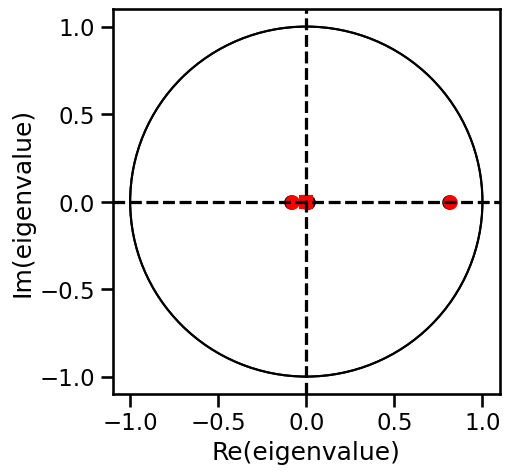

In [65]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]))
plot_eigenvalues(axes, np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='red')

(200, 100, 50)
(200, 100, 4)


Text(0, 0.5, 'activity of latents')

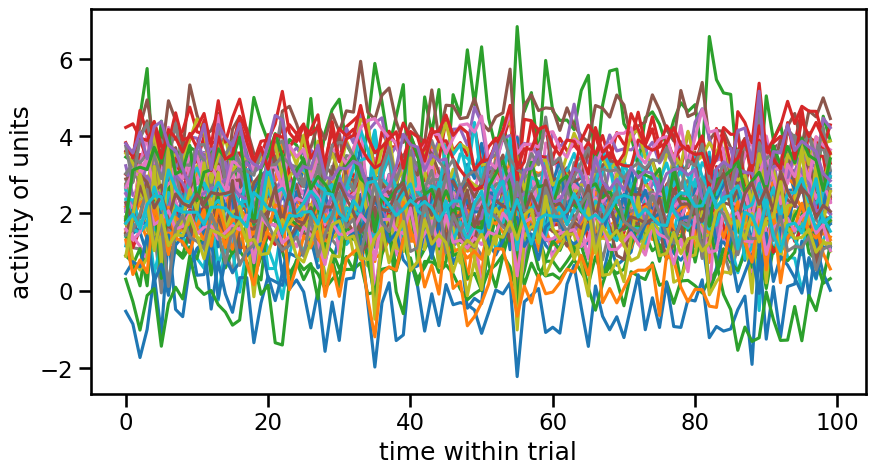

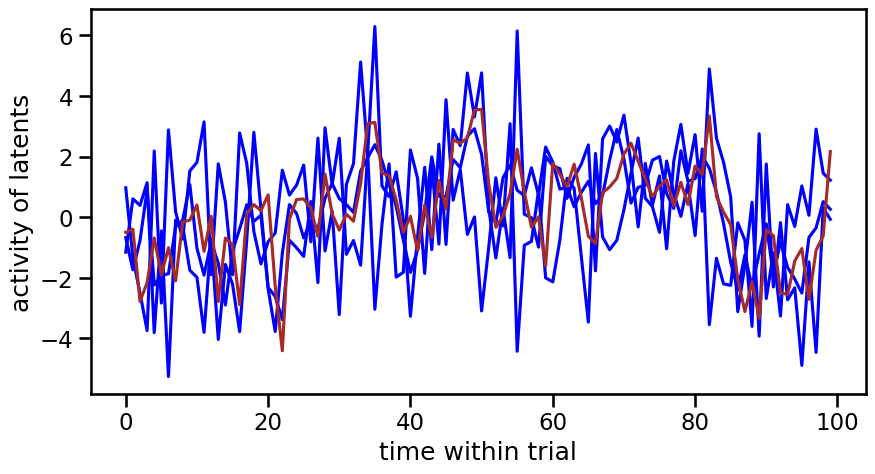

In [66]:
fig, axes = plt.subplots(figsize=(10,5))
print(true_y.shape)
for i in range(D):
    axes.plot(range(T), true_y[0,:,i])

axes.set_xlabel('time within trial')
axes.set_ylabel('activity of units')

fig, axes = plt.subplots(figsize=(10,5))
print(true_x.shape)
for i in range(K1):
    axes.plot(true_x[0,:,i], color='blue')
for i in np.arange(K1,K2+K1):
    axes.plot(true_x[0,:,i], color='brown')
axes.set_xlabel('time within trial')
axes.set_ylabel('activity of latents')

# print(true_x[0,:,-1])

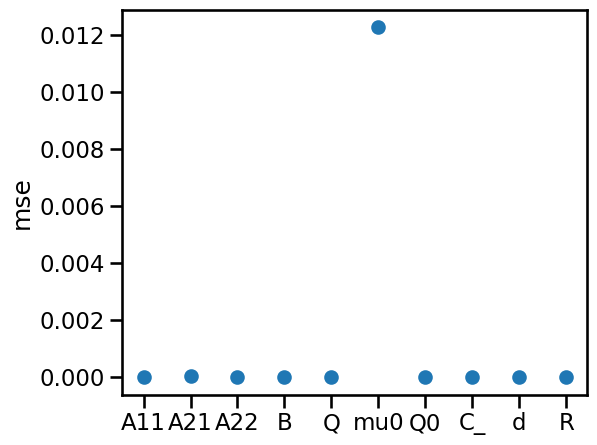

In [56]:
fig, axes = plt.subplots(figsize=(6,5))
plot_mse_parameters(axes, K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

(1000,)


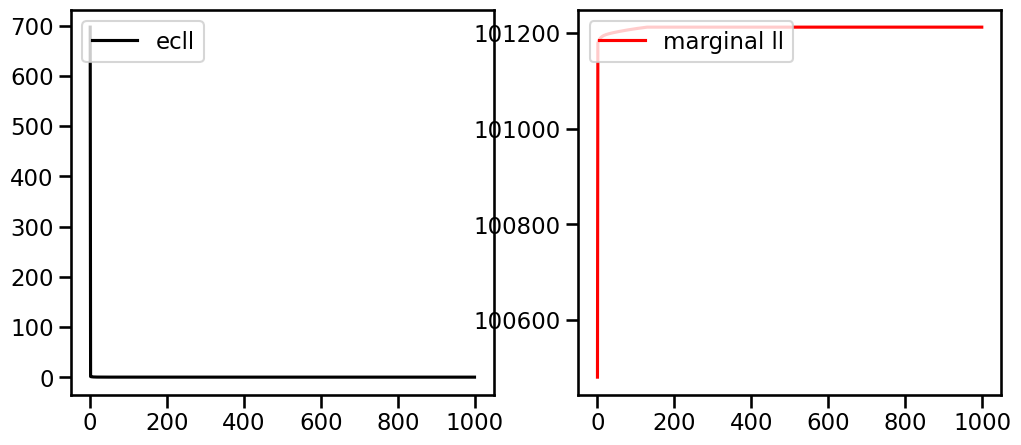

In [36]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
print(elbo.shape)
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll')
axes[1].plot(elbo, color='red', label='marginal ll')
# axes[1].plot(ll.sum(axis=1), color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

In [37]:
# ecll_new, ecll_old, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R, max_iter=max_iter, verbosity=0)

0
(1000,)
1
(1000,)
2
(1000,)
3
(1000,)
4
(1000,)
5
(1000,)
6
(1000,)
7
(1000,)
8
(1000,)
9
(1000,)
10
(1000,)
11
(1000,)
12
(1000,)
13
(1000,)
14
(1000,)
15
(1000,)
16
(1000,)
17
(1000,)
18
(1000,)
19
(1000,)
20
(1000,)
21
(1000,)
22
(1000,)
23
(1000,)
24
(1000,)
25
(1000,)
26
(1000,)
27
(1000,)
28
(1000,)
29
(1000,)


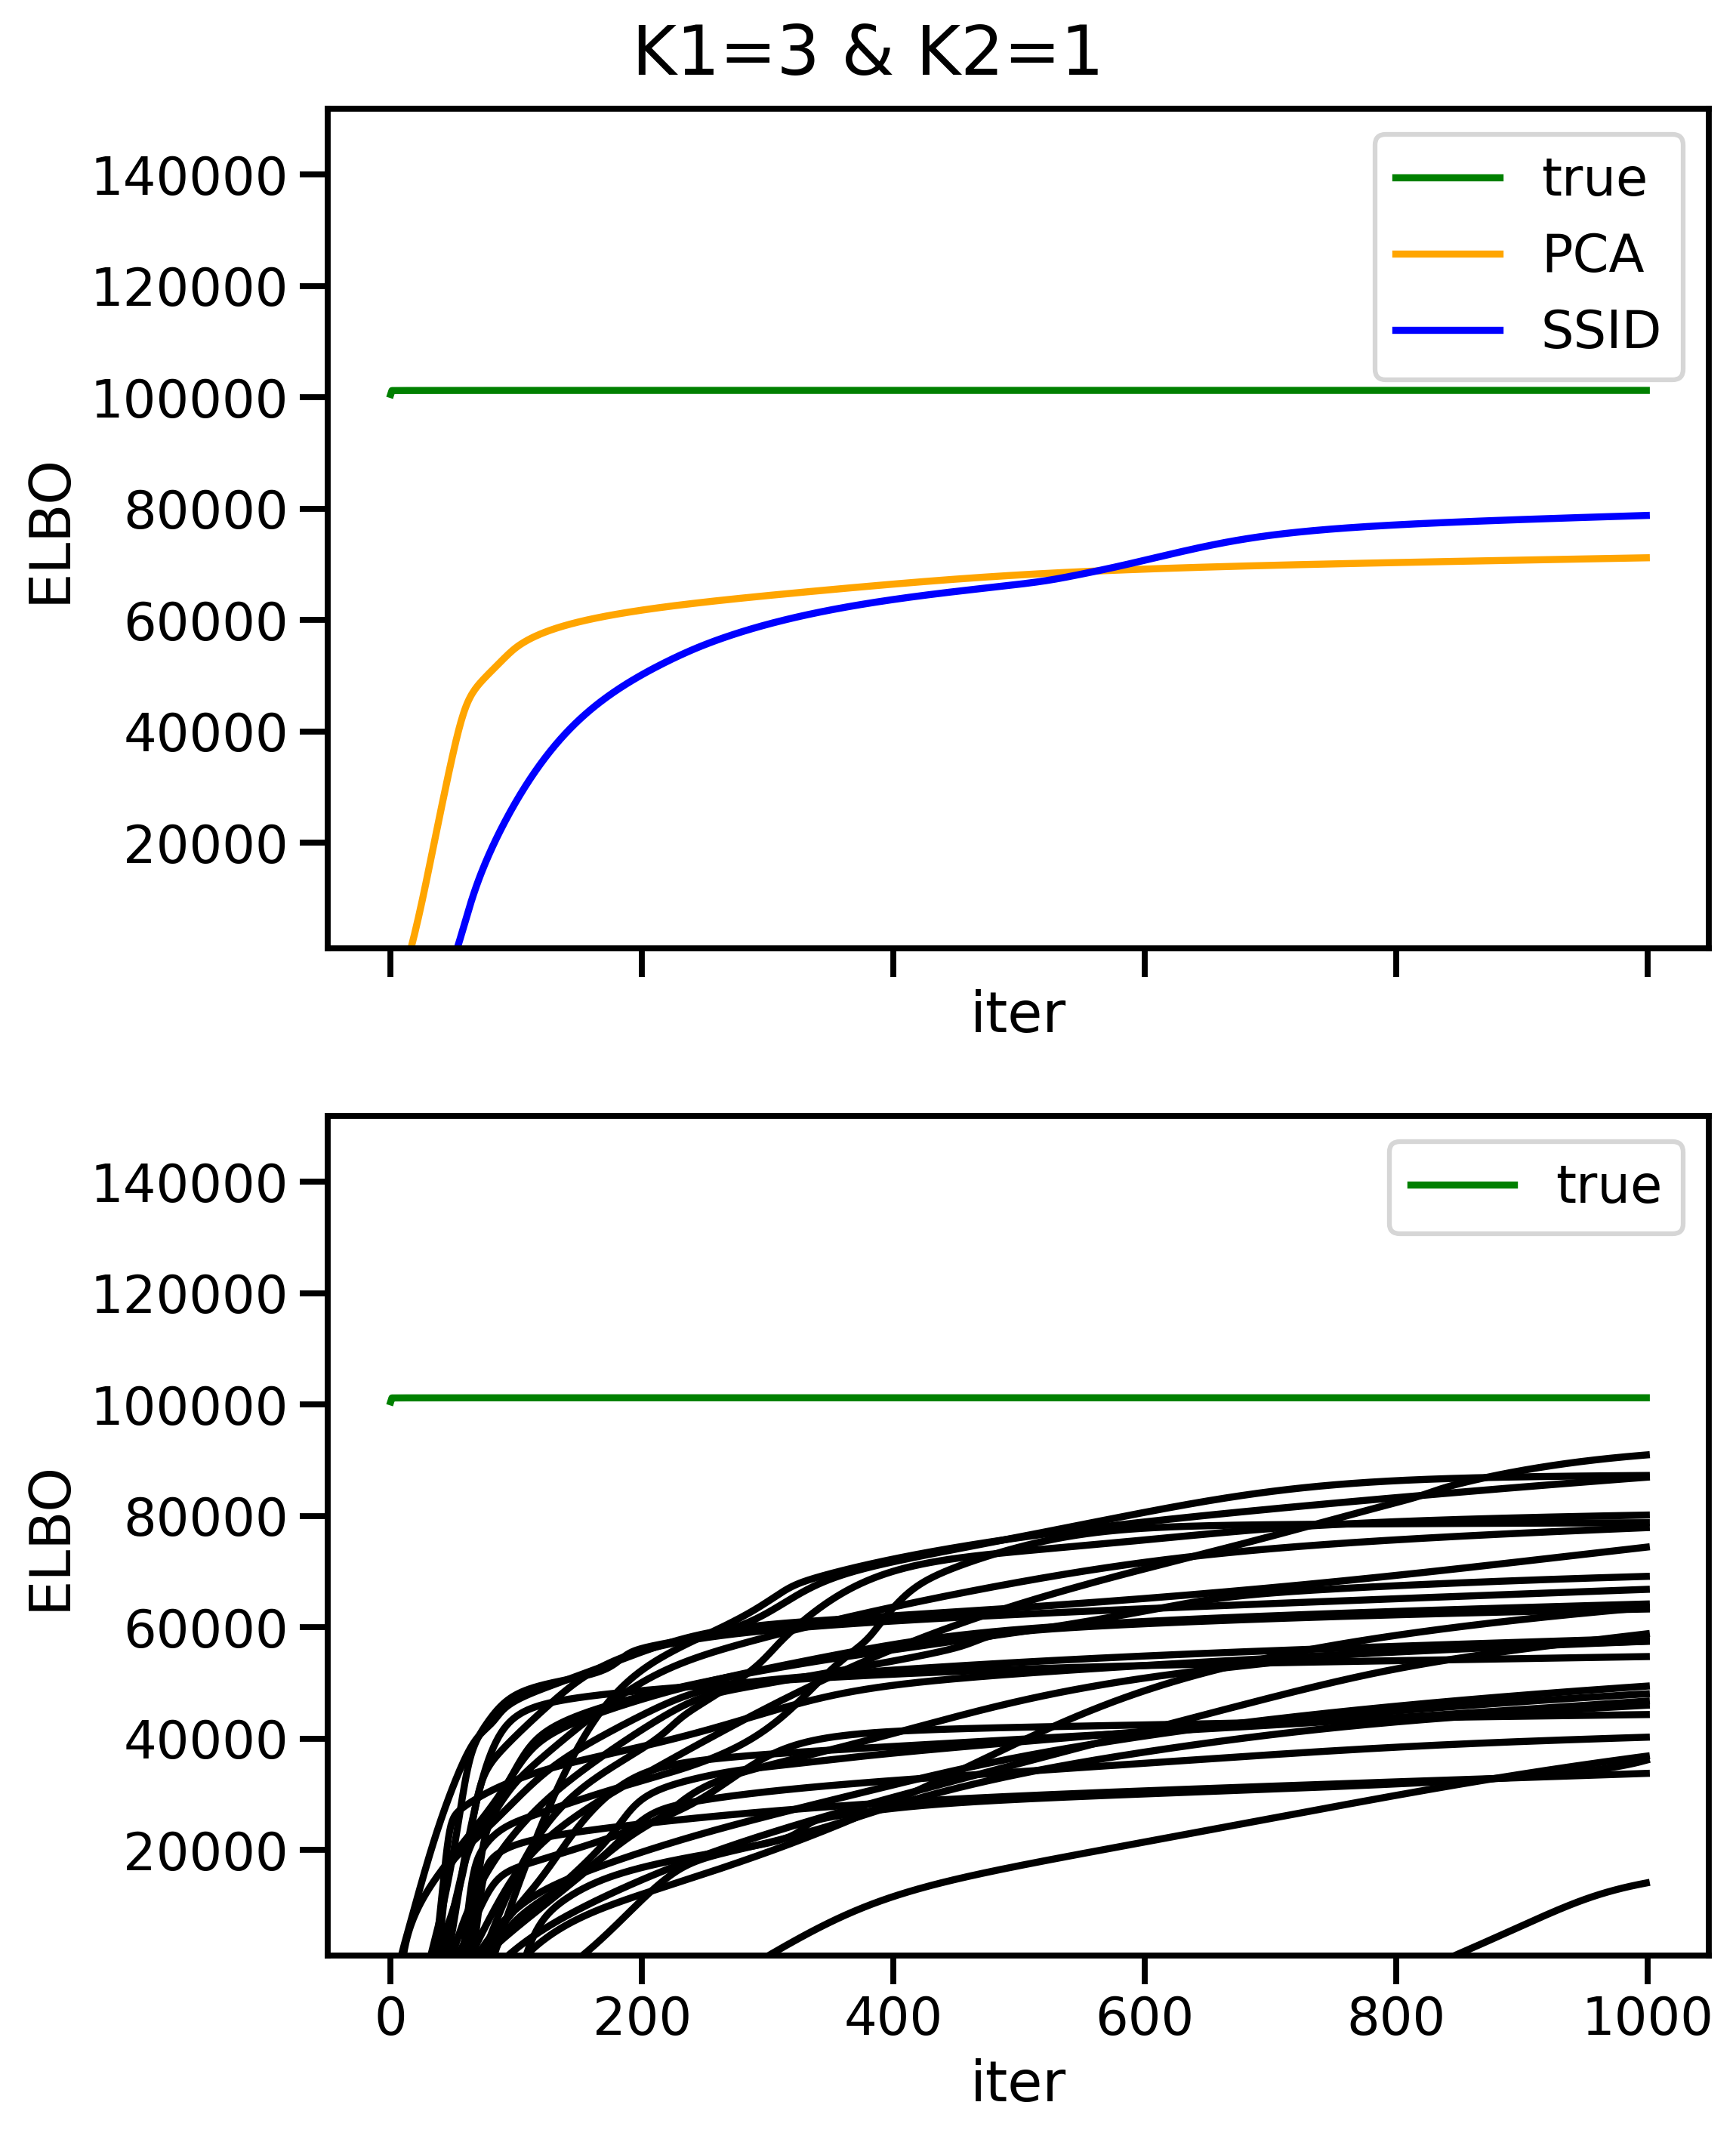

In [38]:
max_iter=1000
eps = 0.1
import mpl_toolkits.axes_grid1.inset_locator as inset
fig, axes = plt.subplots(2,1,figsize=(8,10), dpi=300, sharex=True)
color = ['green','orange','blue'] + ['black' for i in range(27)]
label = ['true','PCA','SSID','best random']

elbos = []

for simulation in range(30):
    print(simulation)
    if os.path.exists(f'models/K1={K1}_K2={K2}_fitted_param_low_rank_simulation={simulation}.npz'):
        fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_low_rank_simulation={simulation}.npz')
        ecll_new=fitted['ecll_new']
        ecll_old=fitted['ecll_old']
        elbo=fitted['elbo']
        ll = fitted['ll']

        print(elbo.shape)
        if elbo.shape[0] == max_iter:
            if simulation != 0:
                elbos.append(elbo[-1])

            if simulation == 0:
                max_elbo = elbo[-1]
                axes[0].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])
                axes[1].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])

            if simulation in [1,2]:
                axes[0].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])
            elif simulation >= 3:
                if np.abs((elbo[-1] - max_elbo)) < S * eps:
                    print('YES')
                    axes[1].plot(range(-5,max_iter-5),elbo, color='red')
                else:
                    axes[1].plot(elbo, color='black')


# axes[0].set_yscale('log')
# axes[1].set_yscale('log')
axes[0].set_ylim(max_elbo*0.01, max_elbo*1.5)
axes[1].set_ylim(max_elbo*0.01, max_elbo*1.5)
axes[0].set_ylabel('ELBO')
axes[1].set_ylabel('ELBO')
axes[0].set_xlabel('iter')
axes[1].set_xlabel('iter')
axes[0].legend()
axes[1].legend()
fig.suptitle(f'K1={K1} & K2={K2}', y=0.95)
fig.tight_layout()

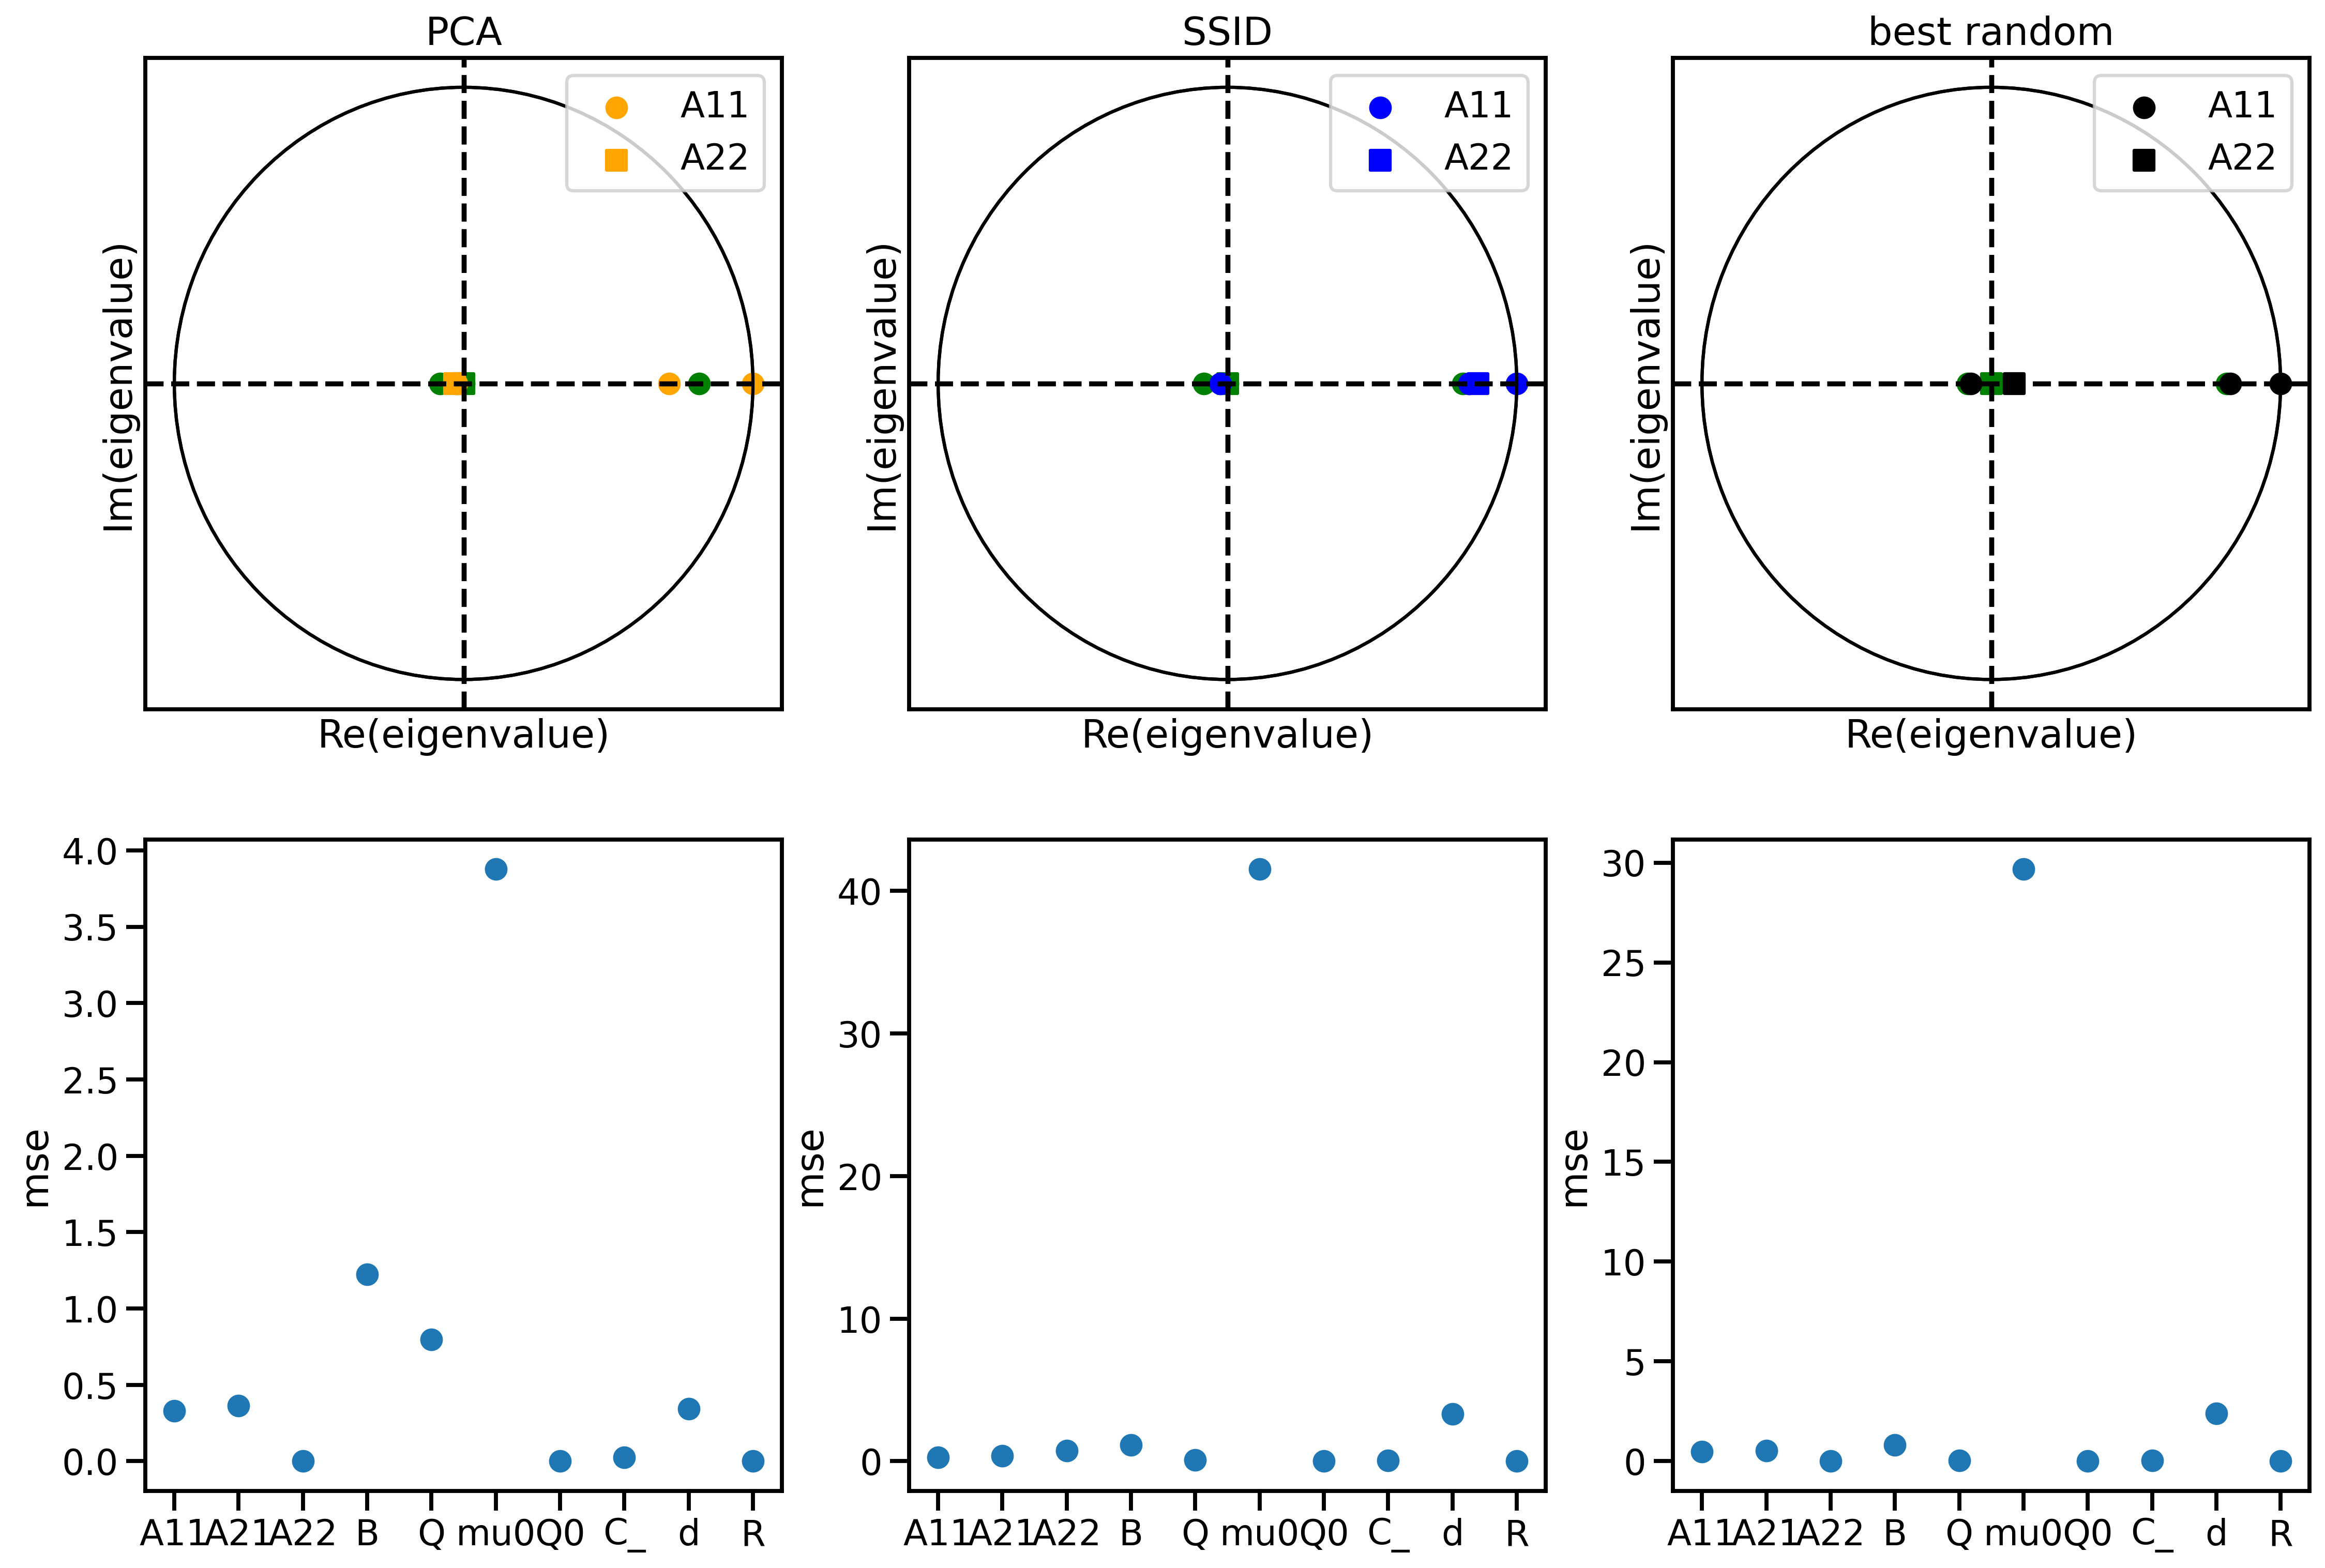

In [39]:
best_ind = np.argmax(elbos)+1


colors = ['green','orange','blue'] + ['black']

fig, axes = plt.subplots(2,3, dpi=300, figsize=(18,12))
ct = 1
for simulation in [1,2,best_ind]:
    if os.path.exists(f'models/K1={K1}_K2={K2}_fitted_param_low_rank_simulation={simulation}.npz'):
        fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_low_rank_simulation={simulation}.npz')
        A=fitted['A']
        B=fitted['B']
        Q=fitted['Q']
        mu0=fitted['mu0']
        Q0=fitted['Q0']
        C=fitted['C']
        d=fitted['d']
        R=fitted['R']
        plot_eigenvalues(axes[0,ct-1], np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='green')
        plot_eigenvalues(axes[0,ct-1], np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]), color=colors[ct], label=['A11','A22'])
        axes[0,ct-1].set_xticks([])
        axes[0,ct-1].set_yticks([])
        axes[0,ct-1].set_title(label[ct])
        axes[0,ct-1].legend(loc='upper right')
        plot_mse_parameters(axes[1,ct-1], K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

    ct+=1

